# Импорт библиотек

нужны для заглушек

In [1]:
import pandas as pd
from dataclasses import dataclass
from pprint import pprint

нужны для получения данных

In [2]:
import requests
import json

# Пример работы с сервисом

Для начала работы с примером нужно локально запустить сервис либо на сервере (тогда надо будет поменять base_url)

In [3]:
base_url = 'http://localhost:5051/forecast/api'

## Заглушки

тут я написал классы для подобия работы с БД, им не нужно уделять внимания

In [4]:
@dataclass
class TimeSeriesDTO:
    """Некий DTO для общения с БД"""
    values: list[float]
    dates: list[str]


class DataLake:
    """Подобие слоя для работы с озером даных"""
    
    @staticmethod
    def get_data_by_id(dataset_uuid: str) -> TimeSeriesDTO:
        """
        подобие функции, которая по id возвращает временной ряд признака из озера данных
        
        просто открывает csv по ключу
        """
        
        tmp = pd.read_csv(f'./raw_data/{dataset_uuid}.csv', sep=';')
        
        return TimeSeriesDTO(
            values=list(tmp['values']),
            dates=list(tmp['date'])
        )

# 1. Для индекса, который хотите предсказать, нужно получить список требуемых признаков

_Признак - временной ряд из озера данных, который нейросеть использует для предсказания индекса. Например, для индекса промышленного производства (ИПП) это будут новостной индекс, Погрузка на сети РЖД, и так далее_
    
### Получить их можно по GET запросу:
data.vavt.ru/forecast/api/v1/{имя_индекса}/features_list
    
- Например, для индекса промышленного производства (ipp) по GET запросу data.vavt.ru/forecast/api/v1/ipp/features_list будет такой результат:


In [115]:
feature_list = requests.get(url=base_url + '/v1/ipp/features_list').json()

In [116]:
feature_list

{'news': {'dataset_uuid': '423f7092-d29b-43da-8209-f100c1fc88cd',
  'description': 'Новостной индекс ЦБ, Россия'},
 'cb_monitor': {'dataset_uuid': '7d38c0d5-6bae-4856-b92c-9858223cfa89',
  'description': 'Оценка изменения спроса на продукцию, товары, услуги (промышленность), пункты, Россия'},
 'business_clim': {'dataset_uuid': '14c74eba-c1a7-4aff-a1e3-0aa473ce8062',
  'description': 'Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия'},
 'interest_rate': {'dataset_uuid': '87d93650-33f7-44b2-96df-6d520fa76c12',
  'description': 'Базовая ставка - краткосрочная, %, Россия'},
 'rzd': {'dataset_uuid': '61265b19-7635-449c-9538-b45e078fb5e9',
  'description': 'Погрузка на сети РЖД, млн тонн, Россия'},
 'consumer_price': {'dataset_uuid': 'f0873ac7-c29f-481b-8f47-e11c7b1b7c82',
  'description': 'Индекс цен на электроэнергию в первой ценовой зоне, рублей за МВт/ч, Россия'},
 'curs': {'dataset_uuid': '5e5ac82a-ab76-4567-b095-92f8064acb51',
  'description': 'Официальный курс доллара США 

__Схема ответа для всех индексов будет одинаковая, будет меняться число признаков, их название и uuid.__

В ответе вам будет полезен database_uuid и название признаков ("news", "rzd", ... )
Описание ("description") может помочь убедиться, что берете и отдаете нужные данные

# 2. Получаем из озера данных данные каждого индекса

Важно отметить, что вся предобработка данных происходит на нашей стороне. Агрегацию по месяцам и фильтрацию по дате проводить не нужно.

Нам нужно сохранить значения и временные отметки индекса. Все индексы начинаются с разного периода времени, для этого нужно их хранить чтобы правильно отрезать нужный период времени, также для агреггации ежедневных данных в помесячные

In [117]:
ipp_data: TimeSeriesDTO = DataLake.get_data_by_id(
    dataset_uuid="c1c92863-1827-405e-b3e4-dea782f57316"
)

приводим к формату в запросе

In [150]:
ipp = {
    "dates": ipp_data.dates,
    "values": ipp_data.values
}

### Пример как должны выглядеть данные

На примере индекса промышленного производства

In [119]:
pd.DataFrame(ipp)\
    .rename(columns={'values': 'Индекс промышленного производства'})\
    .head(5)

,dates,Индекс промышленного производства
0,31.01.2000,110.6
1,29.02.2000,113.3
2,31.03.2000,107.6
3,30.04.2000,117.7
4,31.05.2000,110.8


In [120]:
for feature, value in feature_list.items():
    print(value['dataset_uuid'])

423f7092-d29b-43da-8209-f100c1fc88cd
7d38c0d5-6bae-4856-b92c-9858223cfa89
14c74eba-c1a7-4aff-a1e3-0aa473ce8062
87d93650-33f7-44b2-96df-6d520fa76c12
61265b19-7635-449c-9538-b45e078fb5e9
f0873ac7-c29f-481b-8f47-e11c7b1b7c82
5e5ac82a-ab76-4567-b095-92f8064acb51


In [121]:
features = dict()

for feature, value in feature_list.items():
    data: TimeSeriesDTO = DataLake.get_data_by_id(value['dataset_uuid'])

    features[feature] = {"dates": data.dates, "values": data.values}

### Другой пример как должны выглядеть данные

На примере новостного индекса ЦБ (news)

In [122]:
pd.DataFrame(features['news'])\
    .rename(columns={'values': 'Новостной индекс ЦБ'})\
    .head(5)

,dates,Новостной индекс ЦБ
0,01.02.2004,1.283101
1,01.03.2004,1.316614
2,01.04.2004,1.544784
3,01.05.2004,1.278623
4,01.06.2004,1.160094


Все временные ряды будут иметь такую структуру в запросе. Важно, чтобы значения и отметки времени были одной длины, иначе вернется ошибка валидации

# 3. Формируем запрос

Для этого нужно от пользователя получить список гиперпараметров модели и доверительный интервал.
Например, для модели CatBoost они могут быть следующими:

```json
{
    "depth": 3,
    "learning_rate": 0.1,
    "l2_leaf_reg": 0.005,
    "iterations": 8
}
```

In [147]:
catboost_params = {
    "depth": 3,
    "learning_rate": 1,
    "l2_leaf_reg": 0.005,
    "iterations": 8
}

In [152]:
url = base_url + '/v1/ipp/catboost'

data = {
    "hparams":  catboost_params,     # Гиперпараметры модели
    "ipp":      ipp,                 # Данные ИПП 
    "features": features             # Данные признаков
}

# 4. Отправляем запрос

In [153]:
with requests.post(url=url, json=data) as response:
    print(f'{response.status_code = }')
    forecast = response.json()

response.status_code = 200


In [154]:
forecast

{'previous': [102.38660205326919,
  98.46881537321939,
  101.80134239892172,
  100.04817956723603,
  100.23644832772821,
  100.23644832772821,
  100.23644832772821,
  100.11479885660921,
  100.11479885660921,
  100.11479885660921,
  99.23899386266135,
  99.68990886936159,
  98.65826032730158,
  102.80937378928644,
  100.95705421158712,
  100.11479885660921,
  100.11479885660921,
  100.11479885660921,
  100.11479885660921,
  99.99406168607032,
  104.01946201867071,
  104.01946201867071,
  104.2609567555857,
  104.2609567555857,
  103.92056419159067,
  102.28770422618913,
  103.97649886656899,
  103.37419588380666,
  104.15114736102024,
  103.74497200006117,
  104.52834992160035,
  105.36665923610776,
  104.06867124790553,
  102.73055513137847,
  101.8748755789444,
  101.11025780412754,
  102.067053551856,
  102.95796879533056,
  104.15114736102024,
  102.96802052284761,
  103.82732158641672,
  103.58582684950173,
  103.37506219135457,
  103.13356745443959,
  104.46601171963584,
  104.35

# График

In [155]:
import matplotlib.pyplot as plt
from datetime import datetime

In [157]:
df = pd.DataFrame(ipp)

df.dates = pd.to_datetime(df.dates, format='%d.%m.%Y')
df.head(3)

,dates,values
0,2000-01-31,110.6
1,2000-02-29,113.3
2,2000-03-31,107.6


In [158]:
next_data = [datetime(year=2024, month=i, day=1) for i in range(4, 7)]

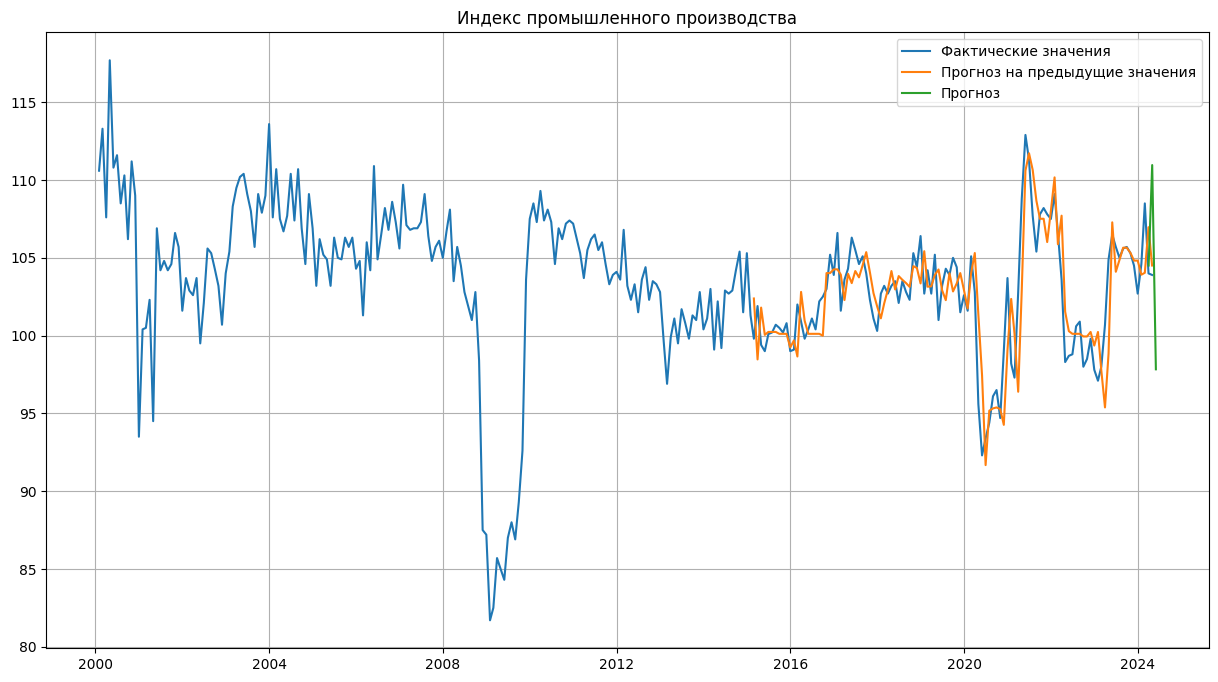

In [164]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.set_title('Индекс промышленного производства')

ax.plot(df.dates, df['values'], label='Фактические значения')
ax.plot(df[df.dates >= datetime(year=2015, month=1, day=1)]['dates'][1:], forecast['previous'], label='Прогноз на предыдущие значения')
ax.plot(next_data, forecast['predict'], label='Прогноз')

ax.legend()
ax.grid()